# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [3]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [4]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [5]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
target_cols = ['Income', 'Total_Spending', 'Age']
center_stats = pd.DataFrame({
    '평균': df[target_cols].mean(),
    '중앙값': df[target_cols].median(),
    '최빈값': df[target_cols].mode().iloc[0],
    '절사평균 5%': df[target_cols].apply(lambda s: trim_mean(s, 0.05))
})

center_stats

,평균,중앙값,최빈값,절사평균 5%
Income,51952.614043,51381.5,51381.5,51740.153426
Total_Spending,605.986583,396.5,46.0,561.119662
Age,55.101968,54.0,48.0,55.074975


In [6]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
q1 = df[target_cols].quantile(0.25)
q3 = df[target_cols].quantile(0.75)
iqr = q3 - q1

disp_stats = pd.DataFrame({
    '표준분산': df[target_cols].var(ddof=1),
    '표준편차': df[target_cols].std(ddof=1),
    'IQR': iqr,
    'CV(%)': (df[target_cols].std(ddof=1) / df[target_cols].mean()) * 100
})

disp_stats

,표준분산,표준편차,IQR,CV(%)
Income,4.584509e+08,21411.466851,32773.25,41.213454
Total_Spending,3.622417e+05,601.865156,976.50,99.319881
Age,1.369668e+02,11.703281,18.00,21.239315


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

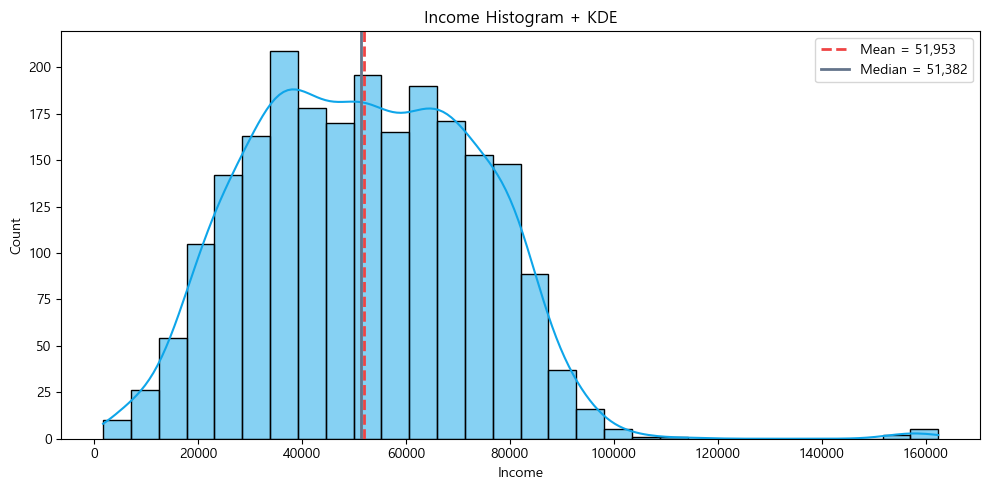

In [7]:
# TODO 1-2(a): Income 히스토그램 + KDE
income = df['Income']
mean_income = income.mean()
median_income = income.median()

plt.figure(figsize=(10, 5))
sns.histplot(income, bins=30, kde=True, color=COLORS['sky'])
plt.axvline(mean_income, color=COLORS['red'], linestyle='--', linewidth=2, label=f"Mean = {mean_income:,.0f}")
plt.axvline(median_income, color=COLORS['slate'], linestyle='-', linewidth=2, label=f"Median = {median_income:,.0f}")
plt.title("Income Histogram + KDE")
plt.xlabel("Income")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

IQR 이상치 기준: lower=-1,395.8, upper=2,510.2
IQR 이상치 개수: 3 / 2,236 (0.13%)


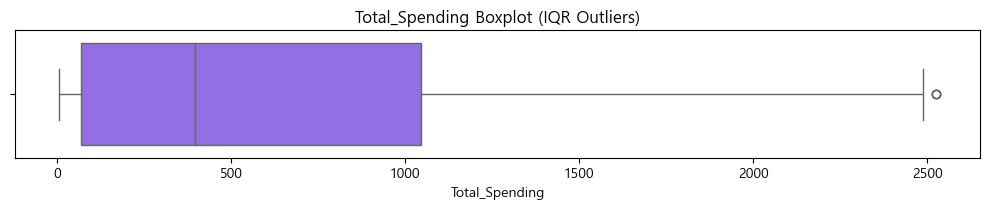

In [8]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
spend = df['Total_Spending']
q1, q3 = spend.quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = spend[(spend < lower) | (spend > upper)]
print(f"IQR 이상치 기준: lower={lower:,.1f}, upper={upper:,.1f}")
print(f"IQR 이상치 개수: {len(outliers):,} / {len(spend):,} ({len(outliers)/len(spend)*100:.2f}%)")

plt.figure(figsize=(10, 2.2))
sns.boxplot(x=spend, color=COLORS['violet'])
plt.title("Total_Spending Boxplot (IQR Outliers)")
plt.xlabel("Total_Spending")
plt.tight_layout()
plt.show()

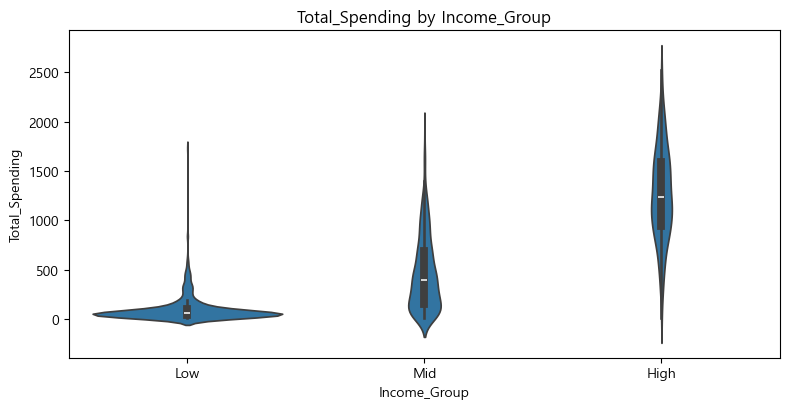

,count,mean,median
Income_Group,,,
Low,746,95.676944,56.0
Mid,745,457.930201,393.0
High,745,1265.037584,1234.0


In [9]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
group_stats = (df
               .groupby('Income_Group', observed=True)['Total_Spending']
               .agg(['count', 'mean', 'median']))

plt.figure(figsize=(8, 4.2))
sns.violinplot(data=df, x='Income_Group', y='Total_Spending', inner='box')
plt.title("Total_Spending by Income_Group")
plt.xlabel("Income_Group")
plt.ylabel("Total_Spending")
plt.tight_layout()
plt.show()

group_stats

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [10]:
spending_names = ['Wines'
                    , 'Fruits'
                    , 'Meat'
                    , 'Fish'
                    , 'Sweets'
                    , 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
spending_cols_6 = ['MntWines'
                , 'MntFruits'
                , 'MntMeatProducts'
                ,'MntFishProducts'
                , 'MntSweetProducts'
                , 'MntGoldProds']

skewness = df[spending_cols_6].apply(lambda s: stats.skew(s, bias=False))
excess_kurt = df[spending_cols_6].apply(lambda s: stats.kurtosis(s, fisher=True, bias=False))

shape_stats = pd.DataFrame({
    'skew': skewness,
    'excess_kurtosis': excess_kurt
})
shape_stats.index = spending_names

shape_stats

,skew,excess_kurtosis
Wines,1.176036,0.600531
Fruits,2.104241,4.069754
Meat,2.085282,5.530136
Fish,1.919970,3.096020
Sweets,2.135674,4.372062
Gold,1.885136,3.558349


In [11]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [12]:
# TODO 1-4: 비즈니스 인사이트 정리
age_mean, age_med = df['Age'].mean(), df['Age'].median()
inc_mean, inc_med = df['Income'].mean(), df['Income'].median()
sp_mean, sp_med = df['Total_Spending'].mean(), df['Total_Spending'].median()
inc_group_spend = df.groupby('Income_Group', observed=True)['Total_Spending'].mean().sort_values()
child_spend = df.groupby('Has_Children')['Total_Spending'].mean()
top_category = df[spending_cols].mean().sort_values(ascending=False).head(3)

print("=======================고객 특성 요약=======================")
print(f"- 연령: 평균 {age_mean:.1f}세, 중앙값 {age_med:.0f}세")
print(f"- 소득: 평균 {inc_mean:,.0f}, 중앙값 {inc_med:,.0f}")
print(f"- 총 소비: 평균 {sp_mean:,.0f}, 중앙값 {sp_med:,.0f} (평균>중앙값이면 오른쪽 꼬리 가능성)")
print('='* 50)

print("\n=======================핵심 발견 사항=======================")
print("\n소득 그룹별 평균 총 소비(낮음→높음)")
print(inc_group_spend.round(1).to_string())
print("\n- 자녀 유무별 평균 총 소비:")
print(child_spend.round(1).to_string())
print("\n- 평균 소비 상위 카테고리 Top 3:")
print(top_category.round(1).to_string())
print('='* 50)

print("\n=======================후속 분석에서 검증할 가설=======================")
print("고소득(High) 고객의 평균 Total_Spending은 저소득(Low) 고객보다 크다.")
print("유자녀 고객과 무자녀 고객의 평균 Total_Spending은 다르다.")
print("Education_Group에 따라 Campaign_Response(캠페인 수락 경험) 비율이 다르다.")

=======================고객 특성 요약=======================
- 연령: 평균 55.1세, 중앙값 54세
- 소득: 평균 51,953, 중앙값 51,382
- 총 소비: 평균 606, 중앙값 396 (평균>중앙값이면 오른쪽 꼬리 가능성)

=======================핵심 발견 사항=======================

소득 그룹별 평균 총 소비(낮음→높음)
Income_Group
Low       95.7
Mid      457.9
High    1265.0

- 자녀 유무별 평균 총 소비:
Has_Children
False    1104.9
True      407.2

- 평균 소비 상위 카테고리 Top 3:
MntWines           304.1
MntMeatProducts    167.0
MntGoldProds        44.0

=======================후속 분석에서 검증할 가설=======================
고소득(High) 고객의 평균 Total_Spending은 저소득(Low) 고객보다 크다.
유자녀 고객과 무자녀 고객의 평균 Total_Spending은 다르다.
Education_Group에 따라 Campaign_Response(캠페인 수락 경험) 비율이 다르다.


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [13]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10


p = df['Response'].mean()
print(f"캠페인 수락률 p = {p:.4f}")


n_trial = 10
p_x2 = stats.binom.pmf(2, n_trial, p)
p_ge3 = stats.binom.sf(2, n_trial, p)  # P(X >= 3) = 1 - P(X <= 2)

print(f"P(X = 2 | n=10)  = {p_x2:.4f}")
print(f"P(X ≥ 3 | n=10)  = {p_ge3:.4f}")

캠페인 수락률 p = 0.1494
P(X = 2 | n=10)  = 0.2752
P(X ≥ 3 | n=10)  = 0.1782


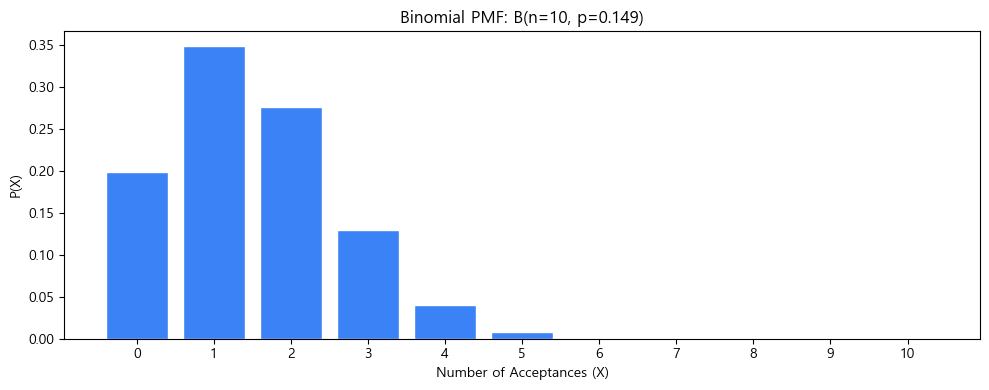

In [14]:
# TODO 2-1(c): 이항분포 PMF 시각화
x = np.arange(0, n_trial + 1)
pmf = stats.binom.pmf(x, n_trial, p)




plt.figure(figsize=(10, 4))
plt.bar(x, pmf, color=COLORS['blue'], edgecolor='white')
plt.title(f"Binomial PMF: B(n={n_trial}, p={p:.3f})")
plt.xlabel("Number of Acceptances (X)")
plt.ylabel("P(X)")
plt.xticks(x)
plt.tight_layout()
plt.show()

In [15]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

expected_accept = n_campaign * p
p_ge15 = stats.binom.sf(14, n_campaign, p)  # P(X >= 15)
k_90 = int(stats.binom.ppf(0.90, n_campaign, p))  # smallest k with CDF >= 0.90




print(f"[n=100]")
print(f"- 기대 수락자 수 E(X) = {expected_accept:.2f}")
print(f"- P(X ≥ 15) = {p_ge15:.4f}")
print(f"- 90% 보장 최소 수락 수 k (P(X ≤ k) ≥ 0.90) = {k_90}")

[n=100]
- 기대 수락자 수 E(X) = 14.94
- P(X ≥ 15) = 0.5358
- 90% 보장 최소 수락 수 k (P(X ≤ k) ≥ 0.90) = 20


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [16]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lambda_hat = web_visits.mean()
var_hat = web_visits.var(ddof=1)


print(f"λ(표본평균) = {lambda_hat:.4f}")
print(f"표본분산(ddof=1) = {var_hat:.4f}")
print(f"평균-분산 차이(절대) = {abs(lambda_hat - var_hat):.4f}")
print(f"평균/분산 비율 = {lambda_hat/var_hat:.4f}  (1에 가까우면 포아송에 더 잘 맞음)")


λ(표본평균) = 5.3189
표본분산(ddof=1) = 5.8898
평균-분산 차이(절대) = 0.5709
평균/분산 비율 = 0.9031  (1에 가까우면 포아송에 더 잘 맞음)


In [17]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)

In [18]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

p_heavy = stats.poisson.sf(heavy_threshold - 1, mu=lambda_hat)  # P(X >= 10)
k_95 = int(stats.poisson.ppf(0.95, mu=lambda_hat))              # smallest k with CDF >= 0.95

print(f"P(X ≥ {heavy_threshold}) = {p_heavy:.4f}  (월 {heavy_threshold}회 이상 방문 고객 비율)")
print(f"서버 용량 기준 k (P(X ≤ k) ≥ 0.95) = {k_95}")

P(X ≥ 10) = 0.0449  (월 10회 이상 방문 고객 비율)
서버 용량 기준 k (P(X ≤ k) ≥ 0.95) = 9


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [19]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교



income = df['Income']
mu_hat = income.mean()
sigma_hat = income.std(ddof=1)

p_lt_30000_theory = stats.norm.cdf(30000, loc=mu_hat, scale=sigma_hat)
p_gt_80000_theory = stats.norm.sf(80000, loc=mu_hat, scale=sigma_hat)

p_lt_30000_emp = (income < 30000).mean()
p_gt_80000_emp = (income > 80000).mean()

cut_top10 = stats.norm.ppf(0.90, loc=mu_hat, scale=sigma_hat)
p_top10_emp = (income >= cut_top10).mean()

print(f"정규 적합 추정치: μ={mu_hat:,.1f}, σ={sigma_hat:,.1f}")
print("\n[확률 비교]")
print(f"P(Income < 30,000)  이론={p_lt_30000_theory:.4f} | 실측={p_lt_30000_emp:.4f}")
print(f"P(Income > 80,000)  이론={p_gt_80000_theory:.4f} | 실측={p_gt_80000_emp:.4f}")

print("\n[상위 10% 소득 기준값]")
print(f"상위 10% 컷(이론 PPF 0.90) = {cut_top10:,.0f}")
print(f"해당 컷 이상 실측 비율 = {p_top10_emp:.4f} (이론상 0.1000에 가까워야 함)")

정규 적합 추정치: μ=51,952.6, σ=21,411.5

[확률 비교]
P(Income < 30,000)  이론=0.1526 | 실측=0.1655
P(Income > 80,000)  이론=0.0951 | 실측=0.0962

[상위 10% 소득 기준값]
상위 10% 컷(이론 PPF 0.90) = 79,393
해당 컷 이상 실측 비율 = 0.1051 (이론상 0.1000에 가까워야 함)


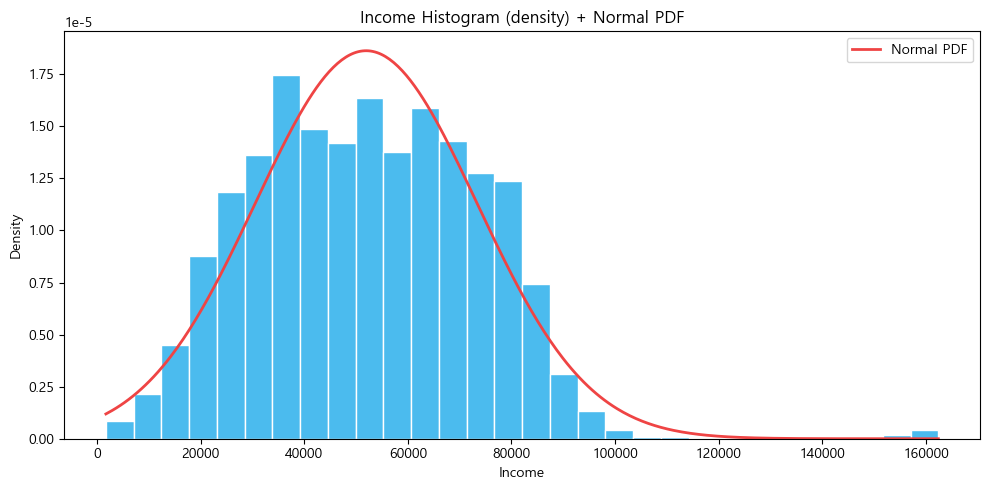

In [20]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
x = np.linspace(income.min(), income.max(), 400)
pdf = stats.norm.pdf(x, loc=mu_hat, scale=sigma_hat)

plt.figure(figsize=(10, 5))
sns.histplot(income, bins=30, stat='density', color=COLORS['sky'], edgecolor='white')
plt.plot(x, pdf, color=COLORS['red'], linewidth=2, label="Normal PDF")
plt.title("Income Histogram (density) + Normal PDF")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
vip_cut = stats.norm.ppf(0.95, loc=mu_hat, scale=sigma_hat)      # 상위 5%
discount_cut = stats.norm.ppf(0.10, loc=mu_hat, scale=sigma_hat) # 하위 10%

print(f"VIP 기준선 (상위 5%): Income ≥ {vip_cut:,.0f}")
print(f"할인 대상 기준선 (하위 10%): Income ≤ {discount_cut:,.0f}")

VIP 기준선 (상위 5%): Income ≥ 87,171
할인 대상 기준선 (하위 10%): Income ≤ 24,513


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [22]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE


spend = df['Total_Spending']
n = spend.shape[0]
x_bar = spend.mean()
s = spend.std(ddof=1)
se = s / np.sqrt(n)

conf_levels = pd.Series([0.90, 0.95, 0.99], index=['90%', '95%', '99%'])
t_crit = conf_levels.apply(lambda c: stats.t.ppf(1 - (1 - c) / 2, df=n - 1))

ci_low = x_bar - t_crit * se
ci_high = x_bar + t_crit * se

ci_table = pd.DataFrame({
    'x̄': x_bar,
    'SE': se,
    't_crit': t_crit,
    'CI_low': ci_low,
    'CI_high': ci_high
})

ci_table

,x̄,SE,t_crit,CI_low,CI_high
90%,605.986583,12.728092,1.645536,585.042054,626.931113
95%,605.986583,12.728092,1.961026,581.026464,630.946702
99%,605.986583,12.728092,2.578031,573.173169,638.799997


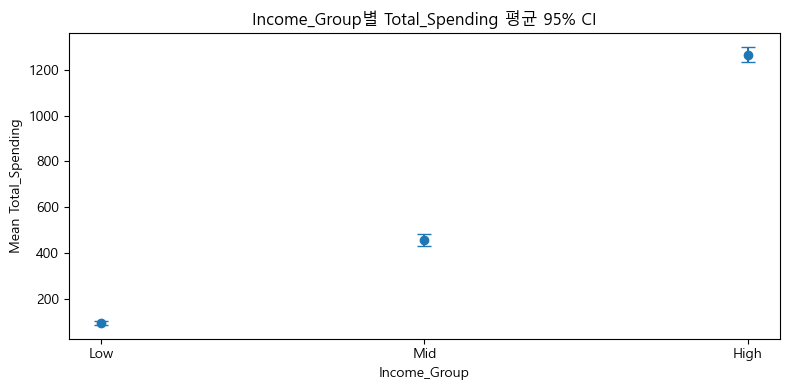

,n,mean,CI_low,CI_high
Income_Group,,,,
Low,746,95.676944,86.734180,104.619707
Mid,745,457.930201,431.472284,484.388119
High,745,1265.037584,1231.350475,1298.724693


In [23]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
group_ci = (df
    .groupby('Income_Group', observed=True)['Total_Spending']
    .agg(n='count', mean='mean', std=lambda s: s.std(ddof=1))
)

group_ci['SE'] = group_ci['std'] / np.sqrt(group_ci['n'])
t_crit = group_ci['n'].apply(lambda n: stats.t.ppf(0.975, df=n - 1))  # 95% two-sided
group_ci['CI_low'] = group_ci['mean'] - t_crit * group_ci['SE']
group_ci['CI_high'] = group_ci['mean'] + t_crit * group_ci['SE']

plt.figure(figsize=(8, 4))
x = np.arange(group_ci.shape[0])
y = group_ci['mean'].values
yerr = np.vstack([y - group_ci['CI_low'].values, group_ci['CI_high'].values - y])

plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5)
plt.xticks(x, group_ci.index.astype(str))
plt.title("Income_Group별 Total_Spending 평균 95% CI")
plt.xlabel("Income_Group")
plt.ylabel("Mean Total_Spending")
plt.tight_layout()
plt.show()

group_ci[['n', 'mean', 'CI_low', 'CI_high']]

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [24]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)


In [25]:
# TODO 3-2(c): 박스플롯 비교 시각화

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [26]:
wines = df['MntWines']
meat = df['MntMeatProducts']
diff = wines - meat

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
t_stat, p_value = stats.ttest_rel(wines, meat)
cohen_d_paired = diff.mean() / diff.std(ddof=1)


print(f"와인 평균: {wines.mean():,.2f}")
print(f"육류 평균: {meat.mean():,.2f}")
print(f"평균 차이(와인-육류): {diff.mean():,.2f}")
print(f"Paired t-test: t={t_stat:.3f}, p-value={p_value:.4f}")
print(f"Cohen's d (paired) = {cohen_d_paired:.3f}")


와인 평균: 304.13
육류 평균: 166.98
평균 차이(와인-육류): 137.14
Paired t-test: t=23.093, p-value=0.0000
Cohen's d (paired) = 0.488


In [27]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [28]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정

---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [29]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
use_welch = None

In [30]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [31]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)

In [32]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g

In [33]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [34]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
# TODO 4-3(b): φ (phi) 계산
# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산

In [35]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [36]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
# TODO 4-4(b): Cohen's w 계산

In [37]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [38]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)

In [39]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

In [40]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [41]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
# TODO 5-2(b): Cohen's h 효과 크기
# TODO 5-2(c): Wilson 신뢰구간

In [42]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [43]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)

---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [44]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [45]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛